<a href="https://colab.research.google.com/github/enviroCar/notebooks/blob/main/enviroCar_track_acceleration_values_animation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install geopandas pandas
!pip install --no-deps envirocar-py 

# set an output directory for the animation and chart:
root_dir = '/content/'

%load_ext autoreload
%autoreload 2

# load dependencies
import pandas as pd
import geopandas as gpd

from envirocar import TrackAPI, DownloadClient, ECConfig

# create an initial but optional config and an api client
config = ECConfig()
track_api = TrackAPI(api_client=DownloadClient(config=config))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# import datetime to help define sample period:
import datetime as dt
# import pandas for data wrangling:
import pandas as pd
# import matplotlib, pyplot and animation for plotting and animating:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# define the animation embed limit for matplotlib:
matplotlib.rcParams['animation.embed_limit'] = 200**128

In [ ]:
track_filter_start = "2021-12-12T11:28:30Z"
track_filter_end = "2021-12-12T11:50:Z"
track_id = "61b5e0887b277d59bd0b2c8c"
track_df = track_api.get_tracks(time_interval=(track_filter_start, track_filter_end))

In [ ]:
print(len(track_df))
df_excerpt = track_df[track_df["track.id"].map(lambda x: x == track_id)]

# remove head and tail as they are unprecise
df_excerpt = df_excerpt.head(len(df_excerpt) - 3)
df_excerpt = df_excerpt.tail(len(df_excerpt) - 3)

df_excerpt

1266


,id,time,geometry,Speed.value,Speed.unit,Intake Temperature.value,Intake Temperature.unit,GPS Speed.value,GPS Speed.unit,CO2 Emission (GPS-based).value,CO2 Emission (GPS-based).unit,GPS Accuracy.value,GPS Accuracy.unit,GPS Bearing.value,GPS Bearing.unit,GPS Altitude.value,GPS Altitude.unit,CO2.value,CO2.unit,Consumption (GPS-based).value,Consumption (GPS-based).unit,MAF.value,MAF.unit,Consumption.value,Consumption.unit,track.id,track.length,track.begin,track.end,sensor.type,sensor.engineDisplacement,sensor.model,sensor.id,sensor.fuelType,sensor.constructionYear,sensor.manufacturer,GPS VDOP.value,GPS VDOP.unit,Intake Pressure.value,Intake Pressure.unit,GPS PDOP.value,GPS PDOP.unit,Throttle Position.value,Throttle Position.unit,Rpm.value,Rpm.unit,GPS HDOP.value,GPS HDOP.unit,Engine Load.value,Engine Load.unit,Minimum GPS Acceleration.value,Minimum GPS Acceleration.unit,Calculated MAF.value,Calculated MAF.unit,Maximum GPS Acceleration.value,Maximum GPS Acceleration.unit,O2 Lambda Voltage ER.value,O2 Lambda Voltage ER.unit,O2 Lambda Voltage.value,O2 Lambda Voltage.unit,Minimum Acceleration.value,Minimum Acceleration.unit,Maximum Acceleration.value,Maximum Acceleration.unit
3,61b5e0887b277d59bd0b2c92,2021-12-12T11:36:39+00:00,POINT (7.65486 51.93550),17.000000,km/h,20.000000,c,11.417277,km/h,5.313940,kg/h,4.551000,%,220.883931,deg,112.999997,m,NaN,NaN,2.005260,l/h,18.650911,l/s,NaN,NaN,61b5e0887b277d59bd0b2c8c,2.780751,2021-12-12T11:36:19Z,2021-12-12T11:42:51Z,car,1868,Caddy Life 1.9,5da599ff44ea8502c16fc0eb,diesel,2008,Volkswagen,0.767304,precision,126.000000,kPa,1.100955,precision,94.000003,%,1849.000000,u/min,0.867304,precision,75.116673,%,0.234694,m/s²,NaN,NaN,2.670683,m/s²,0.288948,ratio,1.756505,V,NaN,NaN,NaN,NaN
4,61b5e0887b277d59bd0b2c93,2021-12-12T11:36:44+00:00,POINT (7.65452 51.93524),30.484670,km/h,20.378462,c,29.980067,km/h,4.540244,kg/h,7.585000,%,226.261950,deg,104.690229,m,NaN,NaN,1.713300,l/h,36.830247,l/s,NaN,NaN,61b5e0887b277d59bd0b2c8c,2.780751,2021-12-12T11:36:19Z,2021-12-12T11:42:51Z,car,1868,Caddy Life 1.9,5da599ff44ea8502c16fc0eb,diesel,2008,Volkswagen,0.700000,precision,163.126587,kPa,1.060150,precision,94.000000,%,1998.676649,u/min,0.800000,precision,52.156864,%,0.488565,m/s²,NaN,NaN,1.242830,m/s²,0.127472,ratio,1.300171,V,0.946285,m/s²,0.946285,m/s²
5,61b5e0887b277d59bd0b2c94,2021-12-12T11:36:49+00:00,POINT (7.65392 51.93493),42.000000,km/h,22.000000,c,40.163904,km/h,2.020206,kg/h,7.585000,%,230.025892,deg,99.999999,m,NaN,NaN,0.762342,l/h,30.410000,l/s,NaN,NaN,61b5e0887b277d59bd0b2c8c,2.780751,2021-12-12T11:36:19Z,2021-12-12T11:42:51Z,car,1868,Caddy Life 1.9,5da599ff44ea8502c16fc0eb,diesel,2008,Volkswagen,0.700000,precision,158.858191,kPa,1.085366,precision,93.999999,%,1807.029556,u/min,0.885366,precision,61.696462,%,0.354251,m/s²,NaN,NaN,0.923695,m/s²,0.115667,ratio,1.138052,V,NaN,NaN,NaN,NaN
6,61b5e0887b277d59bd0b2c95,2021-12-12T11:36:55+00:00,POINT (7.65331 51.93453),14.670437,km/h,21.437999,c,39.814340,km/h,5.070533,kg/h,12.166400,%,220.651898,deg,100.020039,m,NaN,NaN,1.913409,l/h,10.228650,l/s,NaN,NaN,61b5e0887b277d59bd0b2c8c,2.780751,2021-12-12T11:36:19Z,2021-12-12T11:42:51Z,car,1868,Caddy Life 1.9,5da599ff44ea8502c16fc0eb,diesel,2008,Volkswagen,0.700000,precision,104.000000,kPa,1.488093,precision,94.000000,%,899.000000,u/min,1.282140,precision,20.392157,%,-9.423077,m/s²,NaN,NaN,-0.631164,m/s²,1.953094,ratio,2.605347,V,-3.991304,m/s²,-3.991304,m/s²
7,61b5e0887b277d59bd0b2c96,2021-12-12T11:37:00+00:00,POINT (7.65337 51.93455),3.628372,km/h,21.000000,c,0.000000,km/h,2.493283,kg/h,7.585000,%,NaN,NaN,99.999999,m,NaN,NaN,0.940862,l/h,6.720000,l/s,NaN,NaN,61b5e0887b277d59bd0b2c8c,2.780751,2021-12-12T11:36:19Z,2021-12-12T11:42:51Z,car,1868,Caddy Life 1.9,5da599ff44ea8502c16fc0eb,diesel,2008,Volkswagen,0.900000,precision,110.010996,kPa,1.402115,precision,94.000000,%,1094.796073,u/min,1.102115,precision,55.531515,%,0.000000,m/s²,NaN,NaN,0.000000,m/s²,0.161413,ratio,1.463280,V,1.178808,m/s²,1.178808,m/s²
...,

In [ ]:
phenomena = ["Minimum Acceleration.value", "Maximum Acceleration.value"]

In [ ]:
import datetime
from dateutil import parser
df = df_excerpt

# parse the time and use as index
df['time_index'] = pd.to_datetime(df['time'])
df = df.set_index('time_index')

# only select phenomena of interest
df = df[[*phenomena, 'time']]

# resample to 1 second for better animation
df = df.resample('s').fillna("ffill")

#df = df.head(40)

df

,Minimum GPS Acceleration.value,Maximum GPS Acceleration.value,time
time_index,,,
2021-12-12 11:36:39+00:00,0.234694,2.670683,2021-12-12T11:36:39+00:00
2021-12-12 11:36:40+00:00,0.234694,2.670683,2021-12-12T11:36:39+00:00
2021-12-12 11:36:41+00:00,0.234694,2.670683,2021-12-12T11:36:39+00:00
2021-12-12 11:36:42+00:00,0.234694,2.670683,2021-12-12T11:36:39+00:00
2021-12-12 11:36:43+00:00,0.234694,2.670683,2021-12-12T11:36:39+00:00
2021-12-12 11:36:44+00:00,0.488565,1.242830,2021-12-12T11:36:44+00:00
2021-12-12 11:36:45+00:00,0.488565,1.242830,2021-12-12T11:36:44+00:00
2021-12-12 11:36:46+00:00,0.488565,1.242830,2021-12-12T11:36:44+00:00
2021-12-12 11:36:47+00:00,0.488565,1.242830,2021-12-12T11:36:44+00:00


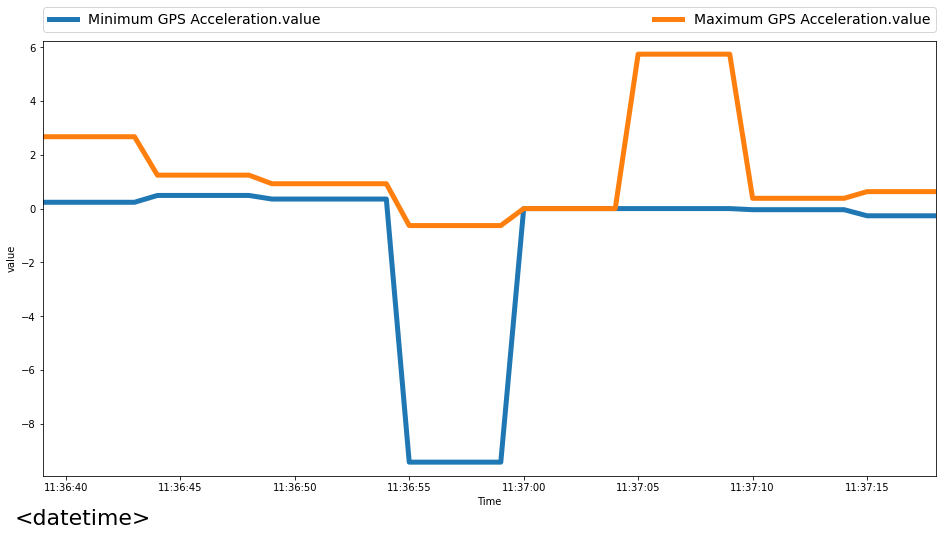

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(16,8))

# bounds
ax.set_xlim(df.index[0],df.index[-1])

# min in phenomena
ymin = 0
ymax = 0
for p in phenomena:
  ymin = min(ymin, df[p].min()-0.5)
  ymax = max(ymax, df[p].max()+0.5)

ax.set_ylim(ymin, ymax)

lines = []
for p in phenomena:
  new_line, = ax.plot(df[p], data= df, marker='', linewidth=5)
  lines.append(new_line)

# set the x-axis label:
plt.xlabel('Time',fontsize=10)

# set the y-axis label:
plt.ylabel('value',fontsize=10)

# add a legend to the plot:
#plt.legend()
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
                      ncol=2, mode="expand", borderaxespad=0., prop={"size":14})

text = fig.text(0.10, 0.05, "<datetime>",
        horizontalalignment='left',
        verticalalignment='center', fontsize=22, color='black')

# show the chart:
plt.show();

In [ ]:
def init_animation():
    for l in lines:
        l.set_data([], [])

    return lines


In [ ]:
# define the function animate, which has the input argument of i:
def animate(i):
    # update the current timestamp
    text.set_text(df["time"].iloc[i])

    # select data up to current index and previous 20 frames
    data =  df.iloc[max(0, int(i-20)):int(i+1)]

    ax.set_xlim(data.index[0],data.index[-1])
    #   initialise xp as an empty list:
    xp = data.index

    i = 0
    for l in lines:
      y1 = data[phenomena[i]]
      l.set_data(xp, y1)
      i = i+1
        
    return lines
  

In [ ]:
# calculate fps
# import dateutil
# total_mesaurements = len(df)
# print(total_mesaurements)
# s = df['time'].iat[0]
# e = df['time'].iat[-1]
# length_s = e-s
# fps = length_s.seconds / total_mesaurements
fps = 1
fps

1

In [ ]:
from matplotlib import rc
rc('animation', html='jshtml')
# call Matplotlib animation.Funcanimation, providing the input arguments of fig, animate, the number of frames and an interval:
interval_ms = int(fps * 1000)
ani = animation.FuncAnimation(fig, animate, init_func=init_animation, frames = len(df), interval=interval_ms)
ani



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Attempting to set identical left == right == 738136.4837847222 results in singular transformations; automatically expanding.
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
# Use the 'ffmpeg' writer:
Writer = animation.writers['ffmpeg']

# Set the frames per second and bitrate of the video:
writer = Writer(fps=1/interval_ms*1000, metadata=dict(artist='Me'), bitrate=1800)
# save the animation to the predefined output directory:
ani.save(root_dir +'animation_video_ffill.mp4', writer=writer)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Attempting to set identical left == right == 738136.4837847222 results in singular transformations; automatically expanding.
  # Remove the CWD from sys.path while we load stuff.
